In [378]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Esse notebook foi feito com base 100% em um "artigo" do medium sobre previsao de acao com regressao.
#O tutorial foi compartilhado no comeco dos nossos estudos no QRio, e entao além de entender o codigo, eu busquei resolver alguns problemas e entender o codigo a fundo.

#De forma resumida, além de "copiar" o codigo para entender os fundamentos, tentei (acabei nao conseguindo) resolver o problema de acerto do codigo, que estava em 99%, oque com certeza é um erro
#visto que o metodo de regressao linear, e qualquer outro, é incapaz disso.
#Provavelmente é algum erro de data leakage que nao consegui revolver. Estudando sobre o assunto pensei que pudesse ser overfitting tambem, mas acredito que nesse caso de previsao de acoes isso nem se aplique, pois nao temos informacoes suficiente pra isso.

#No final de tudo acabei deixando com esse erro, já que por agora acho que nao sei resolver ou entender de onde está surgindo esse vazamento de dados.

In [ ]:
#Deixei os comentarios do tutorial oficial, que estão em Ingles, mas tambem adicionei alguns próprio, em Portugues.

#Link do tutorial/artigo: https://medium.com/codex/stock-predication-using-regression-algorithm-in-python-fb8b426453b9

In [1]:
# Let's start with calling all dependencies that we will use for this exercise 
import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import sklearn as sk
import yfinance as yf  # We will use this library to upload latest data from Yahoo API
%matplotlib inline
plt.style.use('fivethirtyeight')

In [17]:
# define the ticker you will use
vale = yf.Ticker('VALE')
#Display stock information, it will give you a summary description of the ticker
vale.info

Exception: yfinance failed to decrypt Yahoo data response

<AxesSubplot: xlabel='Date'>

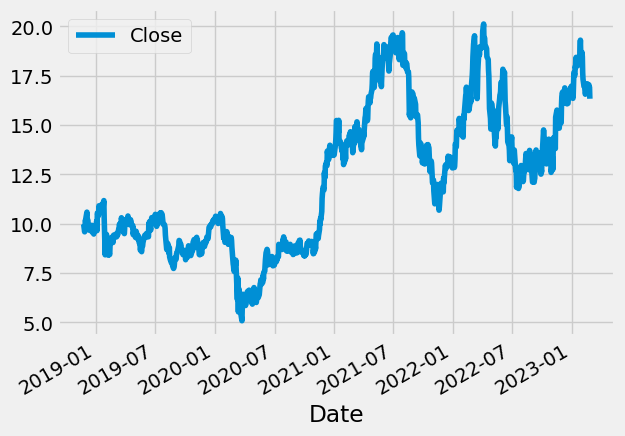

In [42]:
history = vale.history(period="max")
#print(history)
#print('-')
df = pd.DataFrame(history)
df.head(5270)
df.iloc[4200:5270].plot(y='Close')

In [21]:
print('dias =', len(df))
print(f"Qt.Anos (dias/366) = {len(df)/366}")

dias = 5281
Qt.Anos (dias/366) = 14.42896174863388


In [43]:
# defining x and y 
x = df.index
y = df['Close']
y

Date
2002-03-21 00:00:00-05:00     0.922996
2002-03-22 00:00:00-05:00     0.893939
2002-03-25 00:00:00-05:00     0.893939
2002-03-26 00:00:00-05:00     0.917527
2002-03-27 00:00:00-05:00     0.931542
                               ...    
2023-03-07 00:00:00-05:00    16.320000
2023-03-08 00:00:00-05:00    16.719999
2023-03-09 00:00:00-05:00    16.469999
2023-03-10 00:00:00-05:00    16.200001
2023-03-14 00:00:00-04:00    15.980000
Name: Close, Length: 5281, dtype: float64

In [44]:
# Data Exploration
# i like to set up a plot function so i can reuse it at later stages of this analysis 
def df_plot(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

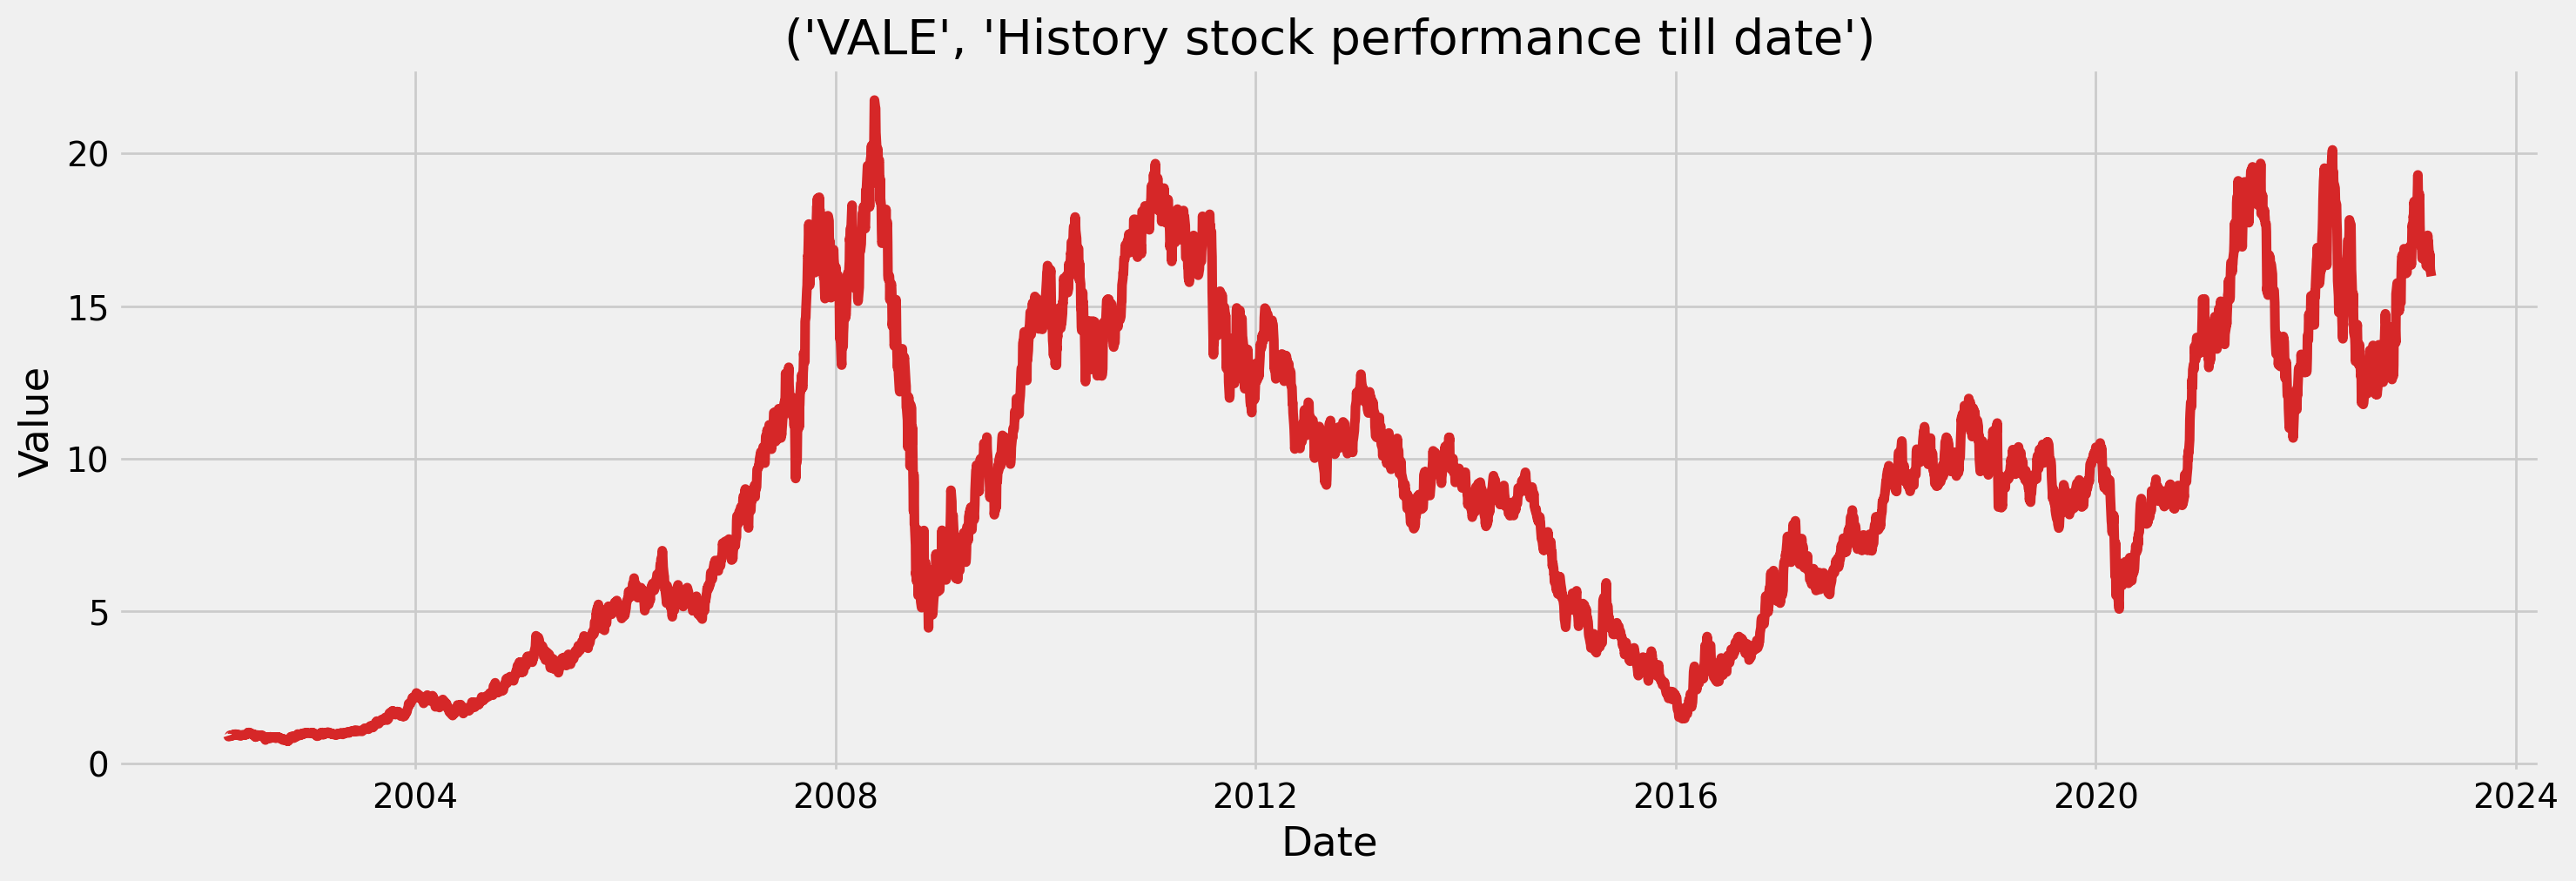

In [45]:
stock_name = "VALE"
title = (stock_name,"History stock performance till date")
df_plot(df, x , y , title=title,xlabel='Date', ylabel='Value',dpi=200)

In [47]:
# Data Processing and scaling
df.reset_index(inplace=True) # to reset index and convert it to column

In [48]:
df.head(6)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-03-21 00:00:00-05:00,0.922996,0.922996,0.922996,0.922996,0,0.0,0.0
1,2002-03-22 00:00:00-05:00,0.914450,0.914450,0.886418,0.893939,44247600,0.0,0.0
2,2002-03-25 00:00:00-05:00,0.890521,0.897358,0.888812,0.893939,7429200,0.0,0.0
3,2002-03-26 00:00:00-05:00,0.893939,0.917868,0.893939,0.917527,4604400,0.0,0.0
4,2002-03-27 00:00:00-05:00,0.921287,0.948635,0.916159,0.931542,13928400,0.0,0.0
5,2002-03-28 00:00:00-05:00,0.922996,0.936670,0.914450,0.936328,6098400,0.0,0.0


In [49]:
df.columns=['date','open','high','low','close','vol','divs','split']

In [50]:
df

,date,open,high,low,close,vol,divs,split
0,2002-03-21 00:00:00-05:00,0.922996,0.922996,0.922996,0.922996,0,0.0,0.0
1,2002-03-22 00:00:00-05:00,0.914450,0.914450,0.886418,0.893939,44247600,0.0,0.0
2,2002-03-25 00:00:00-05:00,0.890521,0.897358,0.888812,0.893939,7429200,0.0,0.0
3,2002-03-26 00:00:00-05:00,0.893939,0.917868,0.893939,0.917527,4604400,0.0,0.0
4,2002-03-27 00:00:00-05:00,0.921287,0.948635,0.916159,0.931542,13928400,0.0,0.0
...,...,...,...,...,...,...,...,...
5276,2023-03-07 00:00:00-05:00,16.700001,16.840000,16.270000,16.320000,31286600,0.0,0.0
5277,2023-03-08 00:00:00-05:00,16.620001,16.910000,16.590000,16.719999,12981900,0.0,0.0
5278,2023-03-09 00:00:00-05:00,16.719999,16.840000,16.430000,16.469999,16344500,0.0,0.0
5279,2023-03-10 00:00:00-05:00,16.389999,16.639999,16.110001,16.200001,18615600,0.0,0.0


In [51]:
df.drop(columns=['divs','split']).head(2) # We are dropping un necessary columns from the set

,date,open,high,low,close,vol
0,2002-03-21 00:00:00-05:00,0.922996,0.922996,0.922996,0.922996,0
1,2002-03-22 00:00:00-05:00,0.914450,0.914450,0.886418,0.893939,44247600


In [55]:
df['date'] = pd.to_datetime(df.date)


In [53]:
df.describe()

,open,high,low,close,vol,divs,split
count,5281.000000,5281.000000,5281.000000,5281.000000,5.281000e+03,5281.000000,5281.000000
mean,8.907974,9.039489,8.761207,8.903680,2.208812e+07,0.002427,0.001326
std,5.120733,5.182152,5.044845,5.117176,1.327764e+07,0.036476,0.056727
min,0.740107,0.756857,0.740107,0.743525,0.000000e+00,0.000000,0.000000
25%,4.784516,4.871184,4.665453,4.763146,1.342800e+07,0.000000,0.000000
50%,8.903524,9.033235,8.778187,8.920984,2.038780e+07,0.000000,0.000000
75%,12.928464,13.092649,12.717898,12.931952,2.845920e+07,0.000000,0.000000
max,21.866275,21.871230,21.321353,21.752337,1.574684e+08,1.559000,3.000000


In [71]:
# NO CODIGO ORIGINAL ELE USA X COMO ['open', 'high','low', 'vol'] E PREVE O ['close'] DO MESMO DIA, SENDO ELE, ESSE CLOSE, O y, OU SEJA, ELE COLETA INFORMACOES DO DIA Z E PREVE O CLOSE DESSE DIA Z.
# MAS EM UM METTING QUE ESTAVAMOS ANALISANDO ESSE MODELO, ACABAMOS PERCEBENDO QUE SERIA MAIS CORRETO FAZER X ['open', 'high','low','close', 'vol'] E y ['close'].shift(-1)
# DESSA FORMA ESTARIAMOS USANDO DADOS DO DIA Z PARA PREVER O y ['close'] DO DIA Z+1, SE REFERINDO ASSIM AO FUTURO/DIA SEGUINTE AO FAZER .shift(-1)

x_hoje = df[['open', 'high','low','close', 'vol']] #hoje
y_amanha = df['close'].shift(-1) #amanha

In [72]:
# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x_hoje, y_amanha, test_size=0.15 , shuffle=False,random_state = 0)
#CRIANDO/SEPARANDO DADOS DE TESTE(15%) E TREINO(85%)

In [59]:
from sklearn.model_selection import TimeSeriesSplit


In [26]:
#tss = TimeSeriesSplit(n_splits = 3)

#for train_index, test_index in tss.split(x_hoje):
    #train_x, test_x = x_hoje.iloc[train_index, :], x_hoje.iloc[test_index,:]
    #train_y, test_y = y_amanha.iloc[train_index], y_amanha.iloc[test_index]

In [60]:
test_x.head(6000)

,open,high,low,close,vol
4488,10.390754,10.545034,10.329043,10.514178,22030300
4489,10.437037,10.437037,10.174761,10.221045,23668300
4490,10.313613,10.398467,10.298186,10.352183,14244400
4491,10.136192,10.282758,10.074480,10.259616,26282200
4492,10.174761,10.182475,9.843060,9.904772,30560900
...,...,...,...,...,...
5276,16.700001,16.840000,16.270000,16.320000,31286600
5277,16.620001,16.910000,16.590000,16.719999,12981900
5278,16.719999,16.840000,16.430000,16.469999,16344500
5279,16.389999,16.639999,16.110001,16.200001,18615600


In [61]:
test_y.head(6000)

4488    10.221045
4489    10.352183
4490    10.259616
4491     9.904772
4492     9.256797
          ...    
5276    16.719999
5277    16.469999
5278    16.200001
5279    15.980000
5280          NaN
Name: close, Length: 793, dtype: float64

In [73]:
#COMO O test_y TERMINA EM NaN POR TER SIDO SHIFTADO, VOU TIRAR A ULTIMA LINHA DELE E DO test_x PARA MANTER A PROPORÇÃO.

test_y = test_y.dropna()
test_y.head(6000) #verifica

4488    10.221045
4489    10.352183
4490    10.259616
4491     9.904772
4492     9.256797
          ...    
5275    16.320000
5276    16.719999
5277    16.469999
5278    16.200001
5279    15.980000
Name: close, Length: 792, dtype: float64

In [74]:
test_x = test_x.drop(len(df)-1)
test_x.head(6000) #verifica

,open,high,low,close,vol
4488,10.390754,10.545034,10.329043,10.514178,22030300
4489,10.437037,10.437037,10.174761,10.221045,23668300
4490,10.313613,10.398467,10.298186,10.352183,14244400
4491,10.136192,10.282758,10.074480,10.259616,26282200
4492,10.174761,10.182475,9.843060,9.904772,30560900
...,...,...,...,...,...
5275,16.730000,16.780001,16.549999,16.690001,46661500
5276,16.700001,16.840000,16.270000,16.320000,31286600
5277,16.620001,16.910000,16.590000,16.719999,12981900
5278,16.719999,16.840000,16.430000,16.469999,16344500


In [75]:
# let's check if total observation makes sense
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(4488, 5)
(792, 5)
(4488,)
(792,)


In [69]:
#ALEM DE TESTES COM sk.learn (linear regression e lasso), TENTEI TAMBEM FAZER UM TESTE COM O MODELO XGBOOST, O QUAL EU JÁ HAVIA OUVIDO FALAR SOBRE.
#USANDO O REGRESSION DO XGBOOST

#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

Training score:  0.9993722185529075
Mean cross-validation score: 0.62
K-fold CV average score: 1.00
-
MSE: 0.19
RMSE: 0.43


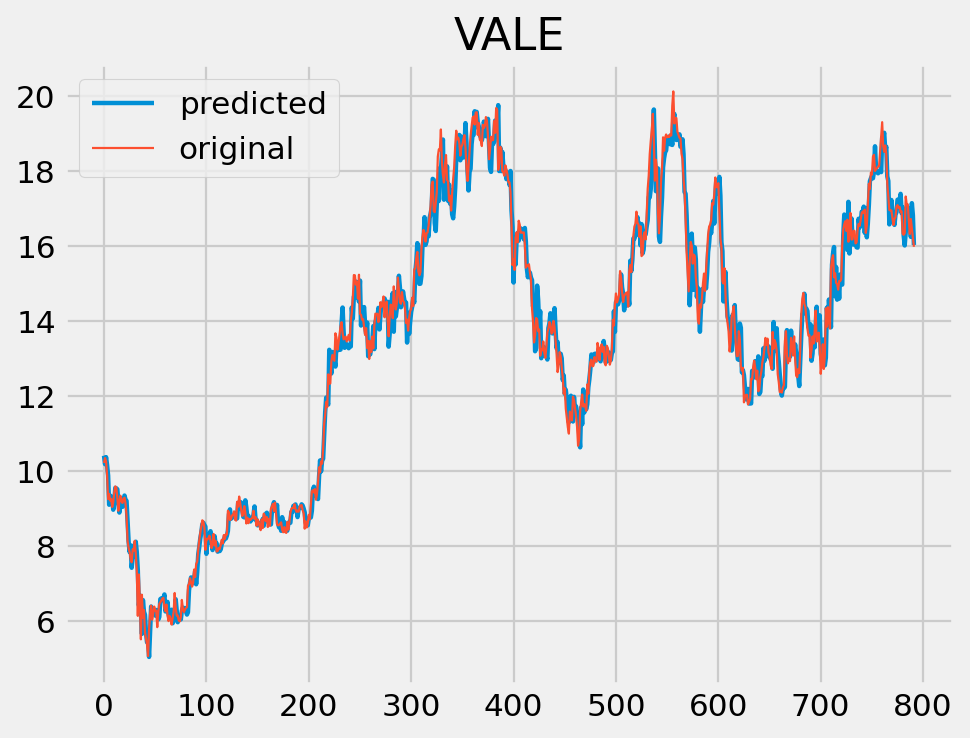

In [82]:
#USANDO XGBOOST

#TENTEI TAMBEM FAZER ESTA PREDICAO COM O PRÓPRIO XGBOOST COM UM TUTORIAL O QUAL ADAPTEI.
#DE QUALQUER MANEIRA, PELOS RESULTADOS EXTREMAMENTE PRECISOS, ESSE MODELO SÓ SERVIU PARA ME CONVENCER MAIS AINDA QUE EXISTE UM DATA LEAKAGE OU ALGO DO TIPO

#https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

#PREPARING DATA

#x_hoje, y_amanha
xtrain, xtest, ytrain, ytest = train_test_split(x_hoje, y_amanha, test_size=0.15, shuffle=False)

ytest = ytest.dropna()
xtest = xtest.drop(len(df)-1)

#DEFINING AND FITTING THE MODEL
xgbr = xgb.XGBRegressor(objective='reg:linear', random_state=0, verbosity=0)

xgbr.fit(xtrain, ytrain) #fit the model with train data.

score = xgbr.score(xtrain, ytrain)
print("Training score: ", score)

scores = cross_val_score(xgbr, xtrain, ytrain,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean()) #training score with cross-validation method

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean()) #training score with KFlold method in cross-validation method
print("-")

#PREDICT TEST DATA
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

#PLOTING ORIGINAL AND PREDICTED TEST DATA
x_ax = range(len(ytest))

plt.figure(dpi=160)
plt.plot(x_ax, ypred, label="predicted", linewidth=2)#, s=4)
plt.plot(x_ax, ytest, label="original", linewidth=1)#, s=3)

plt.title("VALE")
plt.legend()
plt.show()

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [84]:
#USANDO LASSO
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
# TENTATIVA COM GradientBoostingRegressor DO PRÓPRIO sklearn
regression = GradientBoostingRegressor(random_state=0).fit(train_x, train_y)
regression.fit(train_x, train_y)

GradientBoostingRegressor(random_state=0)

In [86]:
#USANDO LASSO
# Train the model
regression = Lasso(alpha=0.1)
regression.fit(train_x, train_y)

c:\Users\cance\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e+01, tolerance: 1.085e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [87]:
regression = LinearRegression()
regression.fit(train_x, train_y)
print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

regression coefficient [-2.12497642e-01  2.12964531e-01  2.20274846e-01  7.78521693e-01
 -3.16050436e-10]
regression intercept 0.01790538631110472


In [ ]:
#JÁ COM O MODELO PRONTO PARA SER TREINADO, A IDEIA AQUI ERA VICIAR O MODELO NO df DE TREINO, MAS NAS LINHAS ABAIXO PODEMOS VER QUE DEU CERTO DEMAIS PRA SER VERDADE.

In [91]:
# the coefficient of determination R² 
regression_confidence = regression.score(test_x, test_y)
print("linear regression confidence: ", regression_confidence)


linear regression confidence:  0.9904152151944569


In [92]:
predicted=regression.predict(test_x)
print(test_x.head())

           open       high        low      close       vol
4488  10.390754  10.545034  10.329043  10.514178  22030300
4489  10.437037  10.437037  10.174761  10.221045  23668300
4490  10.313613  10.398467  10.298186  10.352183  14244400
4491  10.136192  10.282758  10.074480  10.259616  26282200
4492  10.174761  10.182475   9.843060   9.904772  30560900


In [93]:
predicted.shape


(792,)

In [94]:
dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})
dfr.head(790)

,Actual_Price,Predicted_Price
4488,10.221045,10.509394
4489,10.352183,10.213848
4490,10.259616,10.364120
4491,9.904772,10.252033
4492,9.256797,9.893898
...,...,...
5273,17.110001,17.058381
5274,16.690001,17.104448
5275,16.320000,16.660694
5276,16.719999,16.334975


In [95]:
dfr.head()

,Actual_Price,Predicted_Price
4488,10.221045,10.509394
4489,10.352183,10.213848
4490,10.259616,10.364120
4491,9.904772,10.252033
4492,9.256797,9.893898


In [33]:
dfr.index

Int64Index([4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483,
            ...
            5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262],
           dtype='int64', length=789)

In [34]:
df.loc[:,'close']

0        0.922996
1        0.893939
2        0.893939
3        0.917527
4        0.931542
          ...    
5259    16.760000
5260    16.559999
5261    16.719999
5262    16.770000
5263    17.049999
Name: close, Length: 5264, dtype: float64

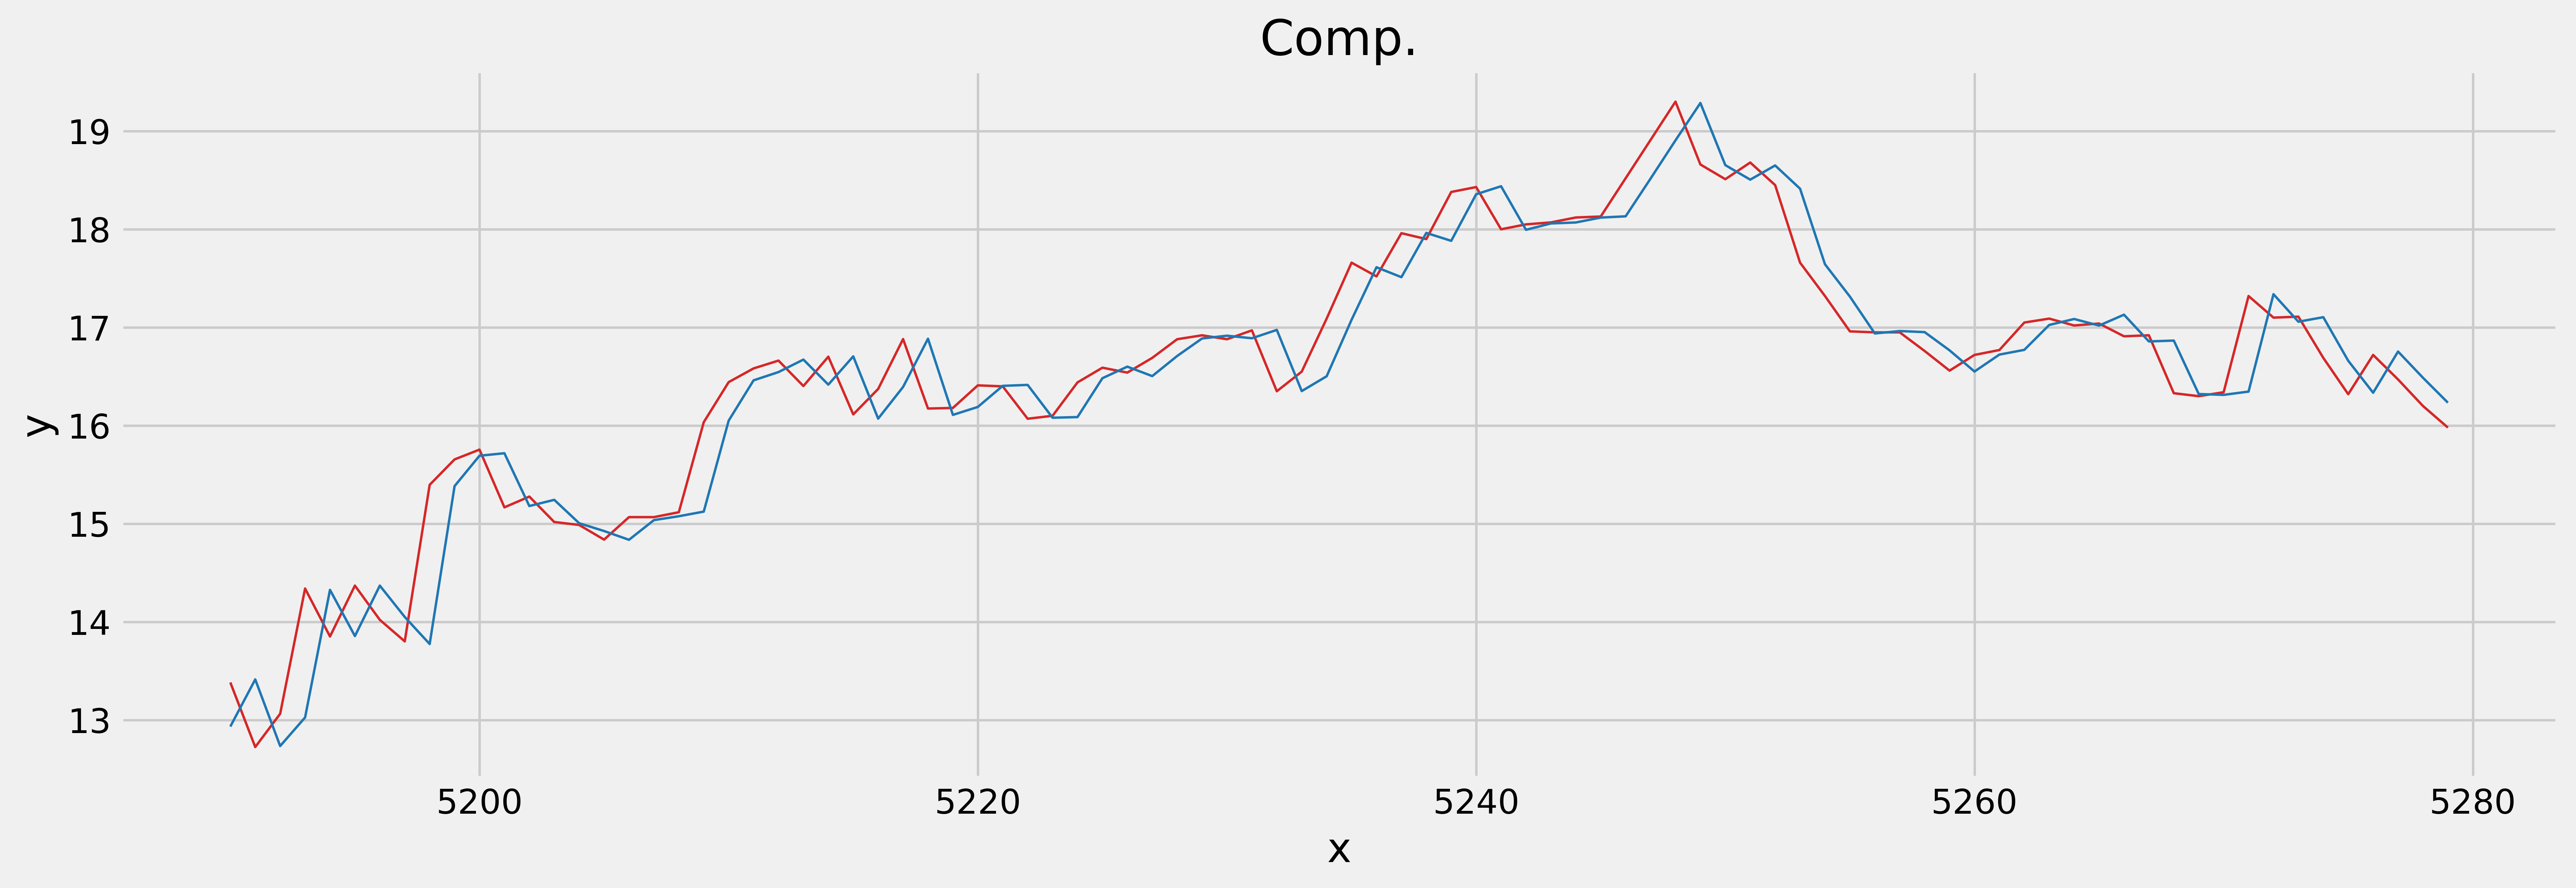

In [96]:
plt.figure(figsize=(16,5), dpi=500)

#plt.plot(df.index, df.loc[:,'close'], color='tab:green', linewidth=1)
plt.plot(dfr.tail(90).index, dfr.tail(90).loc[:,'Actual_Price'], color='tab:red', linewidth=1)
plt.plot(dfr.tail(90).index, dfr.tail(90).loc[:,'Predicted_Price'], color='tab:blue', linewidth=1)

plt.gca().set(title='Comp.', xlabel='x', ylabel='y')

plt.show()

In [36]:
dfr.describe()

,Actual_Price,Predicted_Price
count,789.000000,789.000000
mean,13.221824,13.207829
std,3.774339,3.768641
min,5.075810,5.112290
25%,9.395740,9.389943
50%,13.592937,13.568926
75%,16.338045,16.286950
max,20.119297,20.113533


In [97]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_y, predicted))
print('Mean Squared Error (MSE) :', metrics.mean_squared_error(test_y, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_y, predicted)))

Mean Absolute Error (MAE): 0.2796458319295293
Mean Squared Error (MSE) : 0.13668361980131954
Root Mean Squared Error (RMSE): 0.36970747869270854


In [38]:
dfr.describe()

,Actual_Price,Predicted_Price
count,789.000000,789.000000
mean,13.221824,13.207829
std,3.774339,3.768641
min,5.075810,5.112290
25%,9.395740,9.389943
50%,13.592937,13.568926
75%,16.338045,16.286950
max,20.119297,20.113533
